# Parsing multiple KinExA activity logs.
The KinExA software can export an analysis file for a completed experiment (as a TSV file).  This script operates on a master folder, which itself contains sub-folders each with several TSV files.  Into each of these sub-folders, the script creates an Excel file with the relevant values from all its files, and a graphical summary of the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib as mpl
import glob
import os
import math
import seaborn as sns

sns.set()
sns.set_style("ticks")

# We'll make sure to display the full dataframe, so we're not confused about its nature and contents.
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_rows", None)

os.chdir("/Users/DanielMA/Root/Hinge/Data analysis/Sandbox")

In [2]:
def plot_Kd(results, path):
    """ Takes a dataframe of results (expecting the structure of the abridged dataframe from the function
    dataframes_from_TSVs, as well as a system path.  The function displays and saves a log plot with those 
    experimental results all together."""
    
    plt.clf

    # The parameters for the bars are extracted from the same Results dataframe that we exported to Excel.
    labels = results.loc['File Name']
    kd_hi = results.loc['Kd High']
    kd_lo = results.loc['Kd Low']
    bar_height = kd_hi.sub(kd_lo)
    error1 = results.loc['%Error']
    kd1 = results.loc['Kd']
    cbp1 = results.loc['CBP Molecular Concentration']
    
    
    ind = np.arange(len(results.columns))

    # The color scheme ranges from blue (low error) to red (high error), with the scale centered at 3.0 (white).
    cmap = mpl.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=1, vmax=5)  #Extreme values beyond this take the full red or blue color.
    color_final = cmx.ScalarMappable(norm=norm, cmap=cmap).to_rgba(pd.to_numeric(error1))

    
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))
    fig, ax1 = plt.subplots(figsize=(15, 10))

    ax1.barh(ind, bar_height,left=kd_lo, align='center', color=color_final, edgecolor='k', linewidth=1)

    x_min = 1e-13
    x_max = 1e-8
    y_min = -0.5
    y_max = len(results.columns)-0.5


    ax1.set_xlim(x_min,x_max)
    ax1.set_ylim(y_min,y_max)
    ax1.set_xscale('log')

    ax1.vlines(1e-9,-0.5,len(results.columns), linewidth=3)  #Vertical line at 1 nM.
    ax1.vlines(1e-12,-0.5,len(results.columns), linewidth=3)  #Vertical line at 1 pM
    ax1.grid(which="major", axis='x', color='k', linestyle='--', linewidth=0.5)
    ax1.grid(which="minor", axis='x', color='b', linestyle='-', linewidth=0.1)
    ax1.tick_params(top=True, labeltop=True)

    ax1.hlines(ind+0.5, x_min, x_max, linestyle='--', linewidth=0.5)

    # Red lines mark the Kd prediction for each bar.  Green lines mark the CBP concentration for that run.
    ax1.vlines(kd1,ind-0.5,ind+0.5, linewidth=3, color='r')  #Vertical line at 1 pM
    ax1.vlines(cbp1,ind-0.5,ind+0.5, linewidth=5, color='b')  #Vertical line at 1 pM

    ax1.set_xticklabels(['','100 fM','1 pM','10 pM','100 pM','1 nM','10 nM'])
    ax1.set_yticks(ind)
    ax1.set_yticklabels(labels)
    ax1.tick_params(axis='y',length=0)
    ax1.invert_yaxis()
    
    data_for_table = results.loc[['File Name','Kd','%Error','CBP %Activity','Ratio']]
    col_labels=['File Name','Kd','% Error','% CBP','Ratio']

    file_names = results.loc['File Name'].values.tolist()
    kd2 = ["{0:.0f}".format(x) for x in data_for_table.loc['Kd'].values / 1e-12]
    error2 = ["{0:.2f}".format(x) for x in data_for_table.loc['%Error'].values]
    cbp2 = ["{0:.0f}".format(round(x,0)) for x in data_for_table.loc['CBP %Activity'].values]
    ratio2 = ["{0:.3f}".format(round(x,3)) for x in data_for_table.loc['Ratio'].values]

    cell_text = np.array([file_names, kd2, error2, cbp2, ratio2]).T.tolist()
    col_widths = [1]+[0.5]*4
    
    the_table = ax1.table(cellText=cell_text, cellColours=None,
      cellLoc='center', colWidths=col_widths,
      rowLabels=None, rowColours=None, rowLoc='left',
      colLabels=col_labels, colColours=None, colLoc='center',
      loc='center', bbox=[0.0, -0.6, 1.0, 0.5])
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize (10)

    parent_directory = os.path.dirname(path)
    plt.savefig(parent_directory + '/Graph '+ os.path.basename(path) +'.png',bbox_inches='tight')  
#     plt.show()







def parse_TSV(path_and_name_of_TSV):
    """ Accepts a filename for an nCurve TSV files (exported analysis), and returns
    several dataframes, some of them multi-level: 
    
    master: All the information from the file
    curve_master: All datapoints for graphing the individual curves, each as a dataframe
    summary: The summary columns relevant to the whole file (this output is actually a Pandas series)
    curve_summary: The summary columns relevant to the curves in this nCurve.
    """

    # Master
    master = pd.read_csv(path_and_name_of_TSV, index_col=None, header=0, sep='\t')
    master['File Name'] = os.path.basename(path_and_name_of_TSV)
    number_of_curves = master.iloc[:,26].count()
    master['Number of curves'] = number_of_curves

    # Summary
    summary = master.loc[0,['File Name','Experiment Name','Number of curves','Kd','CBP Molecular Concentration',
                            'Kd High','Kd Low','%Error','CBP %Activity','Comments']]

    # curve_master

    first_curve = master.iloc[:,36:42]   
    first_curve.dropna(axis='index',how='all',inplace=True) # Get rid of annoying NaNs
    curve_list = [first_curve]
    proper_headers = first_curve.columns.values.tolist()

    for i in range(number_of_curves)[1:]:
        n = i*6
        
        current_curve = master.iloc[:,36+n:42+n]  # Next set of data
        column_dict = dict(zip(current_curve.columns.values.tolist(),proper_headers)) # Dictionary for renaming headers.
        current_curve.rename(index=str, columns=column_dict,inplace=True)# Headers now match the first set.
        current_curve.dropna(axis='index',how='all',inplace=True) # Get rid of annoying NaNs
        curve_list.append(current_curve)

    curve_master = pd.concat(curve_list, keys=range(number_of_curves)) 


    # curve_summary
    curve_summary = master.iloc[:number_of_curves,26:36]  # These columns always contain the component curve summaries.
    
    return (master, summary, curve_master, curve_summary)






def process_folder(path):
    """Parse all the nCurves in a particular folder and export Excel files into the same folder"""

    file_paths = glob.glob(path+"/*.tsv")  # Parse all the TSV files in this folder into a list.
    file_paths.sort()  # Sort them, because the list of files out of glob.glob isn't alphabetical.
    file_names = [os.path.basename(x) for x in file_paths]

    frames = [ parse_TSV(path)[1] for path in file_paths]
    summary = pd.concat(frames, axis=1, keys=file_names) 

    writer = pd.ExcelWriter(path + '/Table ' + os.path.basename(path)+ '.xlsx')
    summary.to_excel(writer,'Sheet1')
    writer.save()
    
    
    
    
    
    
def plot_two_nCurves(cm1, cm2):
    """ Takes two nCurve master documents, produces two plots with matched axes and all the data."""

    curve_master = [cm1, cm2]
    number_of_curves = [cm1.index.nlevels+1, cm2.index.nlevels+1]  # For some reason, df.index.nlevels comes 1 short.
    plt.clf

    fig = plt.figure(figsize=(8, 10))

    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212, sharex=ax1)

    axarr = [ax1,ax2]

    for j in [0,1]:
        axarr[j].set_xscale('log')

        for i in range(number_of_curves[j]):
            non_empty = curve_master[j].loc[i]['Calculated Concentration'] > 0  # Removes NaN cells, Sig100, and NSB.
            calculated_x = curve_master[j].loc[i]['Calculated Concentration'][non_empty]
            calculated_y = curve_master[j].loc[i]['Calculated % Free'][non_empty]

            theory_x = curve_master[j].loc[i]['Theory Curve Concentration']
            theory_y = curve_master[j].loc[i]['Theory Curve % Free']

            axarr[j].plot(theory_x, theory_y, linestyle='-', linewidth=2)
            axarr[j].scatter(calculated_x, calculated_y)
    plt.show()

In [3]:
# Preamble Cell

# path_and_name_of_TSV = "/Users/DanielMA/Root/Hinge/Data analysis/Sandbox/Yervoy.tsv"
# master, summary, curve_master, curve_summary = parse_TSV(path_and_name_of_TSV)

sum1 = parse_TSV("/Users/DanielMA/Root/Hinge/Data analysis/Sandbox/Yervoy.tsv")[1]
sum2 = parse_TSV("/Users/DanielMA/Root/Hinge/Data analysis/Sandbox/Y1.tsv")[1]


In [20]:
sum1

File Name                       Yervoy.tsv
Experiment Name                     Yervoy
Number of curves                         3
Kd                             1.58499e-10
CBP Molecular Concentration              0
Kd High                        2.12184e-10
Kd Low                           1.161e-10
%Error                             2.52244
CBP %Activity                      38.3717
Comments                               NaN
Name: 0, dtype: object

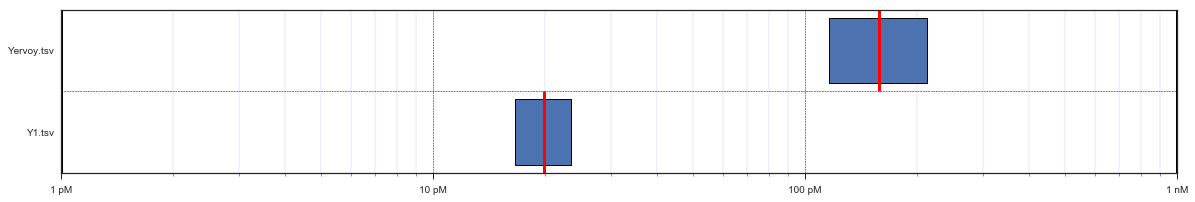

In [25]:
# def plot_nCurve_comparison(sum1,sum2)
# """ Takes two nCurve summary documents, produces a single log plot that compares their Kd ranges """

plt.clf
results = pd.concat([sum1.to_frame(),sum2.to_frame()], axis=1)
fig = plt.figure(figsize=(20, 3))
ax1 = fig.add_subplot(111)

ind = np.arange(2)
labels = results.loc['File Name']
kd_hi = results.loc['Kd High']
kd_lo = results.loc['Kd Low']
bar_height = kd_hi.sub(kd_lo)
error1 = results.loc['%Error']
kd1 = results.loc['Kd']
cbp1 = results.loc['CBP Molecular Concentration']

ax1.barh(ind, bar_height,left=kd_lo, align='center', edgecolor='k', linewidth=1)

x_min = 1e-12
x_max = 1e-9
y_min = -0.5
y_max = 1.5


# ax1.set_xlim(x_min,x_max)
ax1.set_ylim(y_min,y_max)
ax1.set_xscale('log')

ax1.vlines(1e-9,-0.5,len(results.columns), linewidth=3)  #Vertical line at 1 nM.
ax1.vlines(1e-12,-0.5,len(results.columns), linewidth=3)  #Vertical line at 1 pM
ax1.grid(which="major", axis='x', color='k', linestyle='--', linewidth=0.5)
ax1.grid(which="minor", axis='x', color='b', linestyle='-', linewidth=0.1)
# ax1.tick_params(top=True, labeltop=True)

ax1.hlines(ind+0.5, x_min, x_max, linestyle='--', linewidth=0.5)

# Red lines mark the Kd prediction for each bar.  Green lines mark the CBP concentration for that run.
ax1.vlines(kd1,ind-0.5,ind+0.5, linewidth=3, color='r')  #Vertical line at 1 pM
ax1.vlines(cbp1,ind-0.5,ind+0.5, linewidth=5, color='b')  #Vertical line at 1 pM

plt.xticks( [1e-12, 1e-11, 1e-10, 1e-9], ['1 pM','10 pM','100 pM','1 nM'] )
ax1.set_yticks(ind)
ax1.set_yticklabels(labels)
ax1.tick_params(axis='y',length=0)
ax1.invert_yaxis()

# data_for_table = results.loc[['File Name','Kd','%Error','CBP %Activity']]
# col_labels=['File Name','Kd','% Error','% CBP']

# file_names = results.loc['File Name'].values.tolist()
# kd2 = ["{0:.0f}".format(x) for x in data_for_table.loc['Kd'].values / 1e-12]
# error2 = ["{0:.2f}".format(x) for x in data_for_table.loc['%Error'].values]
# cbp2 = ["{0:.0f}".format(round(x,0)) for x in data_for_table.loc['CBP %Activity'].values]

# cell_text = np.array([file_names, kd2, error2, cbp2]).T.tolist()
# col_widths = [1]+[0.5]*4

# the_table = ax1.table(cellText=cell_text, cellColours=None,
#   cellLoc='center', colWidths=col_widths,
#   rowLabels=None, rowColours=None, rowLoc='left',
#   colLabels=col_labels, colColours=None, colLoc='center',
#   loc='right', bbox=[0.0, -0.6, 1.0, 0.5])

# the_table.auto_set_font_size(False)
# the_table.set_fontsize (10)

# parent_directory = os.path.dirname(path)
# plt.savefig(parent_directory + '/Graph '+ os.path.basename(path) +'.png',bbox_inches='tight')  
plt.show()

In [19]:
y_max

1.5